In [468]:
from math import ceil, sqrt
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
df = mushroom.data.features
y = mushroom.data.targets
df['poisonous'] = y

# variable information
print(mushroom.variables)


                        name     role         type demographic  \
0                  poisonous   Target  Categorical        None   
1                  cap-shape  Feature  Categorical        None   
2                cap-surface  Feature  Categorical        None   
3                  cap-color  Feature       Binary        None   
4                    bruises  Feature  Categorical        None   
5                       odor  Feature  Categorical        None   
6            gill-attachment  Feature  Categorical        None   
7               gill-spacing  Feature  Categorical        None   
8                  gill-size  Feature  Categorical        None   
9                 gill-color  Feature  Categorical        None   
10               stalk-shape  Feature  Categorical        None   
11                stalk-root  Feature  Categorical        None   
12  stalk-surface-above-ring  Feature  Categorical        None   
13  stalk-surface-below-ring  Feature  Categorical        None   
14    stal

In [469]:
# В признаке stalk-root есть пустые значения, выбросим соответствующие строки из рассмотрения
df.dropna(inplace=True)
df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
count,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644,...,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644
unique,6,4,8,2,7,2,2,2,9,2,...,7,7,1,2,3,4,6,6,6,2
top,x,y,g,t,n,f,c,b,p,t,...,w,w,p,w,o,p,n,v,d,e
freq,2840,2220,1696,3184,2776,5626,4620,4940,1384,2880,...,3136,3088,5644,5636,5488,3488,1920,2160,2492,3488


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13248\3804506993.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


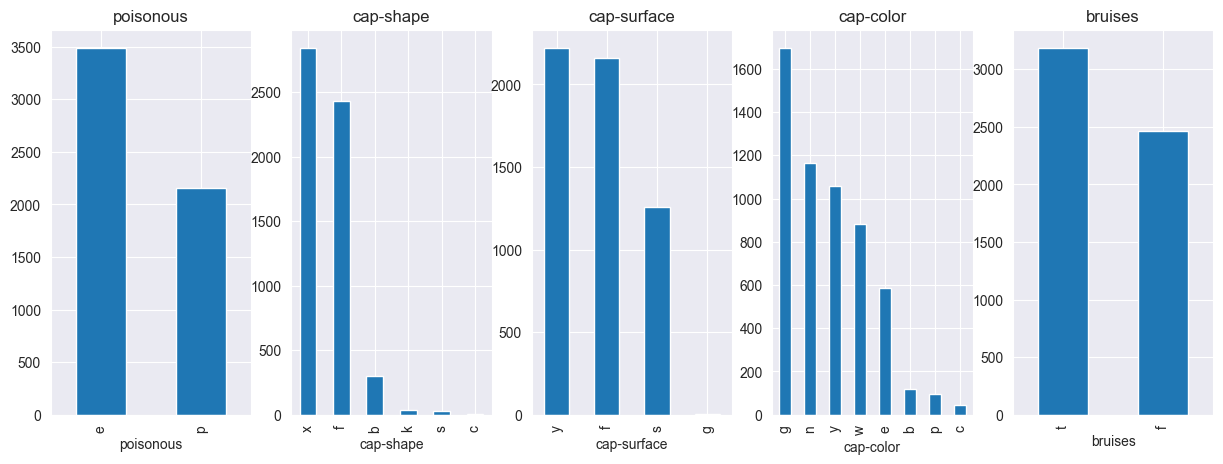

In [470]:
categorical_features = mushroom.variables['name'].tolist()[0:5]
fig, ax = plt.subplots(1, len(categorical_features), figsize=(15, 5))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i]).set_title(categorical_feature)
fig.show()

## Дерево решений

In [471]:
class DecisionTreeNode:
    __max_depth = 10
    __node_entropy = 100000

    def __init__(self, samples, features_left: list[str], depth=1):
        self.__samples = samples    # Samples themselves
        self.__current_depth = depth      # Which depth is noe one, equal to features - features_left
        self.__features_left = features_left  # From which features to split on you can choose

        self.__feature_split = ''    # On which feature we split, diving into every distinct value, not binary
        self.__feature_values: list[str] = []  # All the possible feature values in node
        self.__feature_value_nodes: list[DecisionTreeNode] = []   # Links to all child nodes (other)
        self.__verdict = "NaN"  # Predicted class from current node (exists on every, but calculated only from leaf)
        self.__verdict_prob = 0.0   # If the tree ended somehow, probability with samples

        self.__find_entropy_for_self()

    def get_samples_count(self): # working
        return len(self.__samples)

    def get_entropy_of_node(self):
        return self.__node_entropy

    def __find_entropy_for_self(self): # working
        if self.get_samples_count() == 0:
            self.__node_entropy = 10000.0
        else:
            target = self.__samples['poisonous']
            part_true = (target == 'e').sum() / self.get_samples_count()
            part_false = (target == 'p').sum() / self.get_samples_count()
            if part_true > part_false:
                self.__verdict = 'e'; self.__verdict_prob = part_true
            else:
                self.__verdict = 'p'; self.__verdict_prob = part_false
            if part_true == 0.0 or part_true == 1.0:
                self.__node_entropy = 0
            else:
                self.__node_entropy = -1 * (part_false * np.log(part_false) + part_true * np.log(part_true))

    def __get_info_gain(self):
        info_gain = self.__node_entropy
        for ind, child_node in enumerate(self.__feature_value_nodes):
            info_gain -= child_node.get_entropy_of_node() * (child_node.get_samples_count() / self.get_samples_count())
        return info_gain

    def __set_current_feature_and_split(self, feature: str):
        if feature == '': return
        self.__feature_split = feature
        self.__feature_values = df[feature].unique()
        self.__perform_split_on_current_feature()

    def __perform_split_on_current_feature(self):
        self.__feature_value_nodes = []
        for feature_value in self.__feature_values:
            new_sample_set = self.__samples[self.__samples[self.__feature_split] == feature_value]
            self.__feature_value_nodes.append(DecisionTreeNode(
                new_sample_set,[x for x in self.__features_left if x != self.__feature_split], self.__current_depth + 1,
            )
        )

    def __find_next_best_feature(self):
        if self.__node_entropy == 0.0 or len(self.__features_left) == 0 or\
            self.get_samples_count() == 0 or self.__current_depth == self.__max_depth:
            return
        max_info_gain = 0
        max_info_gain_feature = ''
        for feature in self.__features_left:
            self.__set_current_feature_and_split(feature)
            if self.__get_info_gain() > max_info_gain:
                max_info_gain = self.__get_info_gain()
                max_info_gain_feature = self.__feature_split
        self.__set_current_feature_and_split(max_info_gain_feature)

    def recursive_fit(self):
        self.__find_next_best_feature()
        for node in self.__feature_value_nodes:
            node.recursive_fit()

    def predict(self, sample):
        if len(self.__feature_value_nodes) == 0:
            return self.__verdict
        for ind, feature_value in enumerate(self.__feature_values):
            if sample[self.__feature_split] == feature_value:
                if self.__feature_value_nodes[ind].get_samples_count() == 0:
                    return self.__verdict
                return self.__feature_value_nodes[ind].predict(sample)
        return "dont know"

    def print_tree_from_node(self):
        if len(self.__feature_value_nodes) != 0:
            self.__print_of_depth(f"Node on feature {self.__feature_split}:")
            for ind, feature_node in enumerate(self.__feature_value_nodes):
                self.__print_of_depth(
                    f"\tValue - {self.__feature_values[ind]}, samples {self.__feature_value_nodes[ind].get_samples_count()}"
                )
                self.__feature_value_nodes[ind].print_tree_from_node()
        else:
            self.__print_of_depth(f"Leaf: result {self.__verdict} with prob {self.__verdict_prob}")

    def __print_of_depth(self, string: str):
        print("\t" * self.__current_depth + string)

### Тренировка дерева по критерию прироста информации

In [472]:
params1 = ['cap-shape', 'cap-surface' ,'cap-color', 'bruises',
           'odor', 'gill-attachment', 'gill-spacing', 'gill-size',
           'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
           'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
           'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
           'population', 'habitat'
           ]
df_tree = DecisionTreeNode(df, params1)

df_tree.recursive_fit()
df_tree.print_tree_from_node()

	Node on feature odor:
		Value - p, samples 256
		Leaf: result p with prob 1.0
		Value - a, samples 400
		Leaf: result e with prob 1.0
		Value - l, samples 400
		Leaf: result e with prob 1.0
		Value - n, samples 2776
		Node on feature spore-print-color:
			Value - k, samples 1296
			Leaf: result e with prob 1.0
			Value - n, samples 1296
			Leaf: result e with prob 1.0
			Value - u, samples 0
			Leaf: result NaN with prob 0.0
			Value - h, samples 0
			Leaf: result NaN with prob 0.0
			Value - r, samples 72
			Leaf: result p with prob 1.0
			Value - w, samples 112
			Node on feature cap-color:
				Value - n, samples 48
				Leaf: result e with prob 1.0
				Value - y, samples 8
				Leaf: result p with prob 1.0
				Value - w, samples 8
				Leaf: result p with prob 1.0
				Value - g, samples 8
				Leaf: result e with prob 1.0
				Value - e, samples 0
				Leaf: result NaN with prob 0.0
				Value - p, samples 8
				Leaf: result e with prob 1.0
				Value - b, samples 0
				Leaf: result NaN wi

### Тестирование

In [473]:
# Train-test split
samples_amount = 0.2
random_state = 339106

train = df.sample(frac=samples_amount, random_state=random_state)
test = df.drop(train.index, axis=0)

cols = df.columns
cols = [x for x in np.random.choice(cols, ceil(sqrt(len(cols)))) if x != 'poisonous']

print("Используются признаки:", *cols)

tree = DecisionTreeNode(train, cols)
tree.recursive_fit()
tree.print_tree_from_node()

Используются признаки: bruises bruises veil-type odor
	Node on feature odor:
		Value - p, samples 49
		Leaf: result p with prob 1.0
		Value - a, samples 77
		Leaf: result e with prob 1.0
		Value - l, samples 73
		Leaf: result e with prob 1.0
		Value - n, samples 558
		Node on feature bruises:
			Value - t, samples 388
			Node on feature veil-type:
				Value - p, samples 388
				Leaf: result e with prob 0.9561855670103093
			Value - f, samples 170
			Node on feature veil-type:
				Value - p, samples 170
				Leaf: result e with prob 0.9941176470588236
		Value - f, samples 328
		Leaf: result p with prob 1.0
		Value - c, samples 35
		Leaf: result p with prob 1.0
		Value - m, samples 9
		Leaf: result p with prob 1.0


### Metrics

In [474]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))

    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 'e' else 0
        true = 1 if true == 'e' else 0
        res[pred][true] += 1

    return res

def accuracy(conf):
    return (conf[1][1] + conf[0][0]) / sum(conf.flatten())

def precision(conf):
    return conf[1][1] / (conf[1][1] + conf[1][0])

def recall(conf):
    return conf[1][1] / (conf[1][1] + conf[0][1])

In [475]:
predicted_y = [tree.predict(el) for el in train.iloc]
conf = confusion_matrix(predicted_y, test['poisonous'])
print(conf)
print('Accuracy:', accuracy(conf))
print('Precision', precision(conf))
print('Recall:', recall(conf))

[[ 50. 371.]
 [ 80. 628.]]
Accuracy: 0.6005314437555359
Precision 0.8870056497175142
Recall: 0.6286286286286287


In [475]:
pred_prob = tree.pred_prob(test)
probs = []

for i in range(len(pred_prob)):
    pred, prob = pred_prob[i]
    if pred == 'e':
        probs.append(prob)
    else:
        probs.append(1-prob)